In [17]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime



In [18]:
msft = yf.Ticker("AAPL")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



df = msft.history(period="5y")
print(df)

df = df[['Close']]
df


yfinance.Ticker object <AAPL>
                                 Open        High         Low       Close  \
Date                                                                        
2019-07-15 00:00:00-04:00   49.241672   49.671140   49.219958   49.511902   
2019-07-16 00:00:00-04:00   49.362305   49.729043   49.099317   49.340591   
2019-07-17 00:00:00-04:00   49.232021   49.482944   49.043827   49.063129   
2019-07-18 00:00:00-04:00   49.219960   49.673556   49.147576   49.620476   
2019-07-19 00:00:00-04:00   49.651838   49.823144   48.824269   48.879761   
...                               ...         ...         ...         ...   
2024-07-08 00:00:00-04:00  227.089996  227.850006  223.250000  227.820007   
2024-07-09 00:00:00-04:00  227.929993  229.399994  226.369995  228.679993   
2024-07-10 00:00:00-04:00  229.300003  233.080002  229.250000  232.979996   
2024-07-11 00:00:00-04:00  231.389999  232.389999  225.770004  227.570007   
2024-07-12 00:00:00-04:00  228.919998  232.639

,Close
Date,
2019-07-15 00:00:00-04:00,49.511902
2019-07-16 00:00:00-04:00,49.340591
2019-07-17 00:00:00-04:00,49.063129
2019-07-18 00:00:00-04:00,49.620476
2019-07-19 00:00:00-04:00,48.879761
...,...
2024-07-08 00:00:00-04:00,227.820007
2024-07-09 00:00:00-04:00,228.679993
2024-07-10 00:00:00-04:00,232.979996


In [19]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

shifted_df_np = shifted_df.to_numpy()
shifted_df_np
print(shifted_df_np.shape)

#Day 1     #Todays close   #Close day -1      Close day 2   close day -3 


(1251, 8)


In [20]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

X = shifted_df_np[:, 1:]

y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape



[[-0.95985913 -0.96405449 -0.97547904 ... -0.9731188  -0.96920984
  -0.96700947]
 [-0.96029933 -0.95985913 -0.96320538 ... -0.96691545 -0.97238261
  -0.96898285]
 [-0.96457241 -0.96029933 -0.95891091 ... -0.97515972 -0.96600937
  -0.97217901]
 ...
 [ 0.9538458   0.94461512  0.97429028 ...  0.93244005  0.9451121
   0.88883889]
 [ 1.          0.9538458   0.99055127 ...  0.94668664  0.98536325
   0.9594521 ]
 [ 0.94193174  1.          1.         ...  1.          1.
   1.        ]]


(torch.Size([1188, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1188, 1]),
 torch.Size([63, 1]))

In [21]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [22]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(1, 16, 2)
model.to(device)
model



torch.Size([16, 7, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


learning_rate = 0.003
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()


Epoch: 1

Val Loss: 0.005
***************************************************

Epoch: 2

Val Loss: 0.005
***************************************************

Epoch: 3

Val Loss: 0.009
***************************************************

Epoch: 4

Val Loss: 0.003
***************************************************

Epoch: 5

Val Loss: 0.007
***************************************************

Epoch: 6

Val Loss: 0.004
***************************************************

Epoch: 7

Val Loss: 0.008
***************************************************

Epoch: 8

Val Loss: 0.003
***************************************************

Epoch: 9

Val Loss: 0.002
***************************************************

Epoch: 10

Val Loss: 0.002
***************************************************

Epoch: 11

Val Loss: 0.005
***************************************************

Epoch: 12

Val Loss: 0.003
***************************************************

Epoch: 13

Val Loss: 0.006
**********************

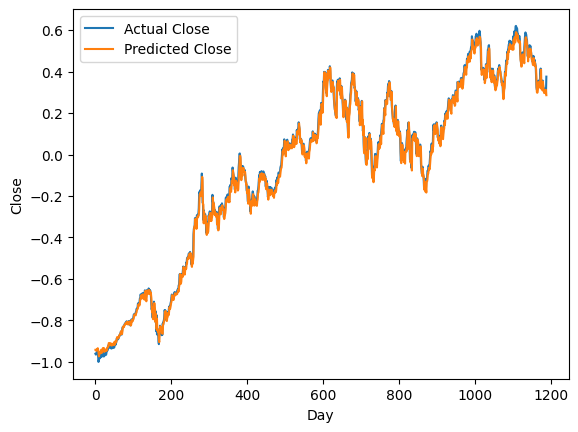

torch.Size([1188, 1])
(1188, 1)
(1188,)


In [24]:
plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)


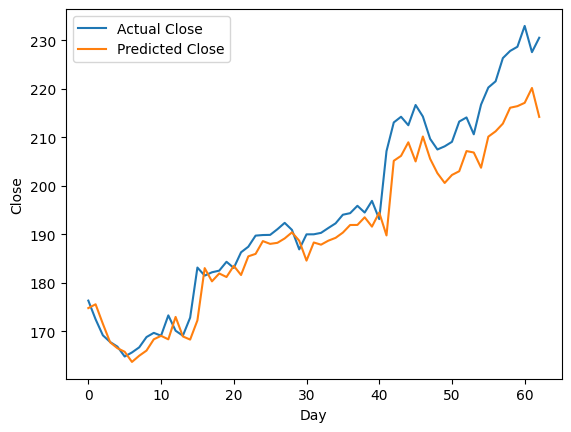

array([174.76650587, 175.55347009, 171.52591453, 167.70646241,
       166.49229332, 165.75640954, 163.66259175, 164.94001096,
       165.99923947, 168.32372584, 169.04818128, 168.32213764,
       172.94615462, 168.91883228, 168.27208175, 172.23383553,
       183.01577655, 180.28804151, 181.91167322, 181.17710831,
       183.48922786, 181.59199911, 185.44585841, 185.95050441,
       188.58674057, 188.01631222, 188.23197348, 189.13813836,
       190.39101275, 188.66630023, 184.56235862, 188.30264258,
       187.84952404, 188.67459105, 189.25997953, 190.34240067,
       191.9106205 , 191.92235981, 193.49795975, 191.57508388,
       194.47979709, 189.75642911, 205.15487373, 206.17462783,
       208.96952794, 205.02252049, 210.16717092, 205.56381158,
       202.60086272, 200.58068496, 202.23266816, 203.00314238,
       207.16063002, 206.86813014, 203.72414378, 210.13501832,
       211.23197755, 212.82440346, 216.10237568, 216.42640066,
       217.11244513, 220.17818237, 214.20913686])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train


test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


test_predictions



Test Results:
                        Date      Actual   Predicted
0  2024-04-12 00:00:00-04:00  176.310867  174.766506
1  2024-04-15 00:00:00-04:00  172.456086  175.553470
2  2024-04-16 00:00:00-04:00  169.150573  171.525915
3  2024-04-17 00:00:00-04:00  167.772445  167.706462
4  2024-04-18 00:00:00-04:00  166.813736  166.492293
..                       ...         ...         ...
58 2024-07-08 00:00:00-04:00  227.820008  216.102376
59 2024-07-09 00:00:00-04:00  228.679993  216.426401
60 2024-07-10 00:00:00-04:00  232.979996  217.112445
61 2024-07-11 00:00:00-04:00  227.570006  220.178182
62 2024-07-12 00:00:00-04:00  230.539996  214.209137

[63 rows x 3 columns]
                        Date      Actual   Predicted   Signal
0  2024-04-12 00:00:00-04:00  176.310867  174.766506  Neutral
1  2024-04-15 00:00:00-04:00  172.456086  175.553470      Buy
2  2024-04-16 00:00:00-04:00  169.150573  171.525915      Buy
3  2024-04-17 00:00:00-04:00  167.772445  167.706462  Neutral
4  2024-04-18 00:

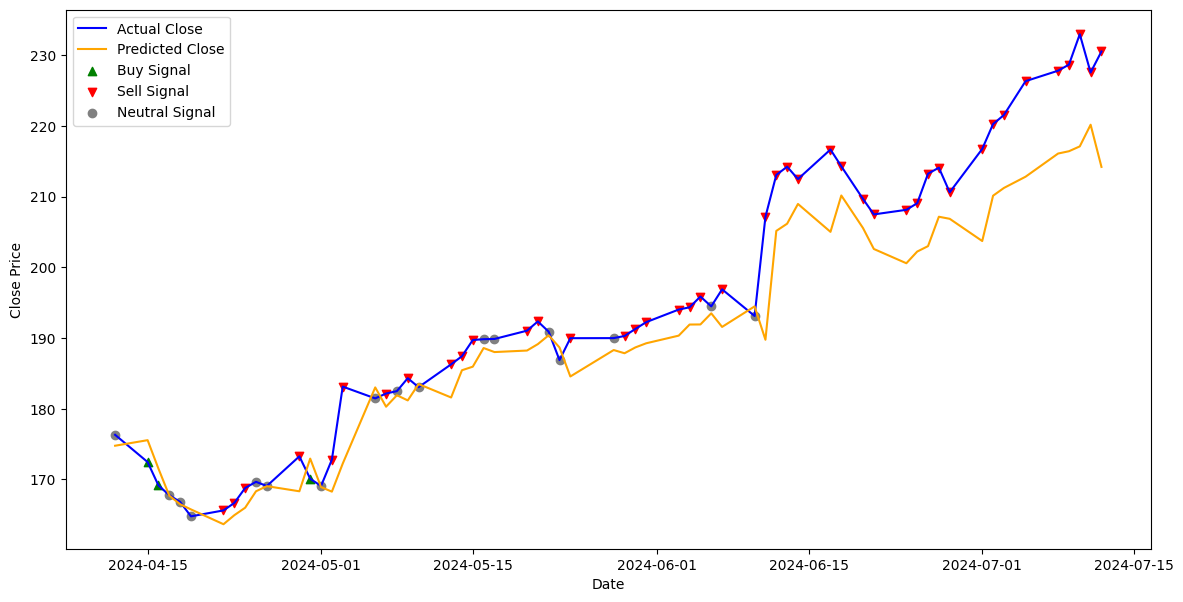

In [26]:
test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)


def generate_trading_signals(test_results_df, neutral_threshold=0.01):
    test_results_df['Signal'] = 'Neutral'

    test_results_df.loc[test_results_df['Predicted'] >
                        test_results_df['Actual'] * (1 + neutral_threshold), 'Signal'] = 'Buy'
    test_results_df.loc[test_results_df['Predicted'] <
                        test_results_df['Actual'] * (1 - neutral_threshold), 'Signal'] = 'Sell'

    return test_results_df


test_results_df_with_signals = generate_trading_signals(test_results_df)
print(test_results_df_with_signals)

# Visualization of trading signals
plt.figure(figsize=(14, 7))
plt.plot(test_results_df['Date'], test_results_df['Actual'],
         label='Actual Close', color='b')
plt.plot(test_results_df['Date'], test_results_df['Predicted'],
         label='Predicted Close', color='orange')
buy_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Buy']
sell_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Sell']
neutral_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Neutral']
plt.scatter(buy_signals['Date'], buy_signals['Actual'],
            label='Buy Signal', marker='^', color='g')
plt.scatter(sell_signals['Date'], sell_signals['Actual'],
            label='Sell Signal', marker='v', color='r')
plt.scatter(neutral_signals['Date'], neutral_signals['Actual'],
            label='Neutral Signal', marker='o', color='gray')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
